# torch.autograd
![](../img/comp-graph.png)

In [3]:
import torch
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
print(x)
print(y)
print(w)
print(b)
print(z)
print(loss)

tensor([1., 1., 1., 1., 1.])
tensor([0., 0., 0.])
tensor([[ 1.6237,  0.0208, -1.0186],
        [ 0.0337,  0.7166,  0.1573],
        [ 0.5393,  0.4423,  0.7971],
        [ 0.4908,  0.3754, -0.9478],
        [ 2.3768, -0.9482,  0.1330]], requires_grad=True)
tensor([ 0.0895, -0.0146, -0.6726], requires_grad=True)
tensor([ 5.1538,  0.5922, -1.5516], grad_fn=<AddBackward0>)
tensor(2.1281, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [4]:
x.requires_grad_(False)

tensor([1., 1., 1., 1., 1.])

In [5]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")
print(z.requires_grad)
print(x.requires_grad)

Gradient function for z = <AddBackward0 object at 0x7e76d411b310>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7e76d411a1d0>
True
False


In [6]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.3314, 0.2146, 0.0583],
        [0.3314, 0.2146, 0.0583],
        [0.3314, 0.2146, 0.0583],
        [0.3314, 0.2146, 0.0583],
        [0.3314, 0.2146, 0.0583]])
tensor([0.3314, 0.2146, 0.0583])


In [7]:
# disabling gradient tracking
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


In [ ]:
z = torch.matmul(x, w)+b
z_det = z.detach() # 拒绝追踪
print(z_det.requires_grad)

# 冻结某些参数 or 加速推理（测试时）

False


# Exercise

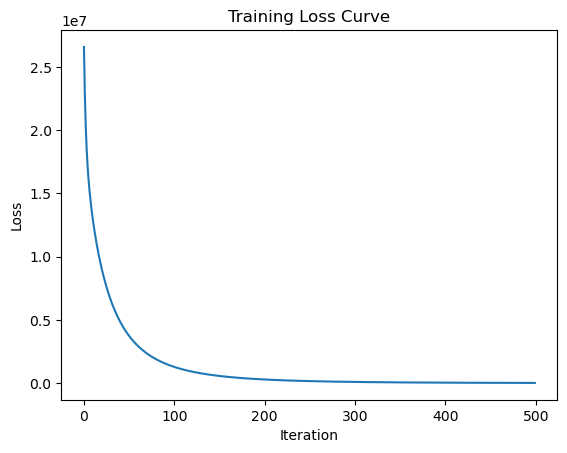

In [ ]:
device = torch.device('cpu')

# N: batch size, D_in: input dimension, H: hidden dimension, D_out: output dimension
N, D_in, H, D_out = 64, 1000, 100, 10

# Random training data
x = torch.randn(N, D_in, device=device)   # input features (64, 1000)
y = torch.randn(N, D_out, device=device)  # target outputs (64, 10)

# Random weight initialization
w1 = torch.randn(D_in, H, device=device)  # layer-1 weights (1000, 100)
w2 = torch.randn(H, D_out, device=device) # layer-2 weights (100, 10)

learning_rate = 1e-7  # step size
loss_list = []        # store loss at each step

# Training loop
for t in range(500):
    # Forward pass
    h = x.mm(w1)            # hidden layer linear transform (64, 100),h = x * w1
    h_relu = h.clamp(min=0) # ReLU activation (64, 100)
    y_pred = h_relu.mm(w2)  # output layer linear transform (64, 10),y_pred = h_relu * w2

    # Mean-squared-error loss
    loss = (y_pred - y).pow(2).sum() # L=Σ(y_pred - y)^2
    loss_list.append(loss.item())

    # Backward pass: compute gradients
    grad_y_pred = 2.0 * (y_pred - y)        # output gradient (64, 10),∂L/∂y_pred = 2(y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)    # gradient w.r.t w2 (100, 10), # ∂L/∂w2 = ∂L/∂y_pred × ∂y_pred/∂w2

    grad_h_relu = grad_y_pred.mm(w2.t())    # gradient after ReLU (64, 100),∂L/∂h_relu = ∂L/∂y_pred × ∂y_pred/∂h_relu
    grad_h = grad_h_relu.clone()            # copy
    grad_h[h < 0] = 0                       # ReLU gradient mask (zero negatives)

    grad_w1 = x.t().mm(grad_h)              # gradient w.r.t w1 (1000, 100),∂L/∂w1 = xᵀ × ∂L/∂h

    # Parameter update (gradient descent)
    w1 -= learning_rate * grad_w1 # w1 = w1 - η × ∂L/∂w1
    w2 -= learning_rate * grad_w2 # w2 = w2 - η × ∂L/∂w2

# Plot loss curve
from matplotlib import pyplot as plt
plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

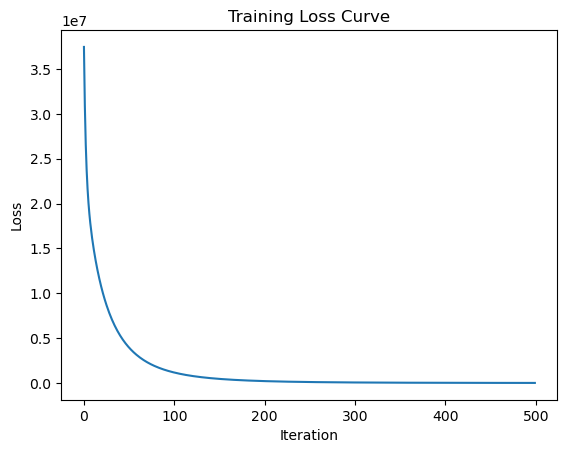

In [ ]:
import torch
from matplotlib import pyplot as plt

# Device configuration
device = torch.device('cpu')

# Hyper-parameters and data
N, D_in, H, D_out = 64, 1000, 100, 10
x = torch.randn(N, D_in, device=device)          # input tensor (batch_size, input_dim)
y = torch.randn(N, D_out, device=device)         # target tensor (batch_size, output_dim)

# Weight tensors with automatic differentiation enabled
w1 = torch.randn(D_in, H, device=device, requires_grad=True)   # layer-1 weights
w2 = torch.randn(H, D_out, device=device, requires_grad=True)  # layer-2 weights

learning_rate = 1e-7
loss_list = []  # record loss for plotting

# Training loop
for t in range(500):
    # Forward pass
    h = x.mm(w1)                # linear transformation: (N, H)
    h_relu = h.clamp(min=0)     # ReLU activation
    y_pred = h_relu.mm(w2)      # output layer: (N, D_out)

    # Compute loss (mean squared error)
    loss = (y_pred - y).pow(2).sum()
    loss_list.append(loss.item())

    # Backward pass: compute gradients
    loss.backward() # autograd to compute w1.grad and w2.grad

    # Parameter update (gradient descent)
    with torch.no_grad(): # in case the update operation is recorded
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad
        # Reset gradients to zero for next iteration
        w1.grad.zero_()
        w2.grad.zero_()

# Plot training loss
plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()